<a href="https://colab.research.google.com/github/Rohanrathod7/Kaggle_Notebooks/blob/main/Predicting_the_Beats-per-Minute_of_Songs/Notebook01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the catboost library
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


# Introduction

This notebook presents a comprehensive solution for the **"Predicting the Beats-per-Minute of Songs"** Kaggle competition. We'll walk through every step of the machine learning pipeline, from data exploration to submission, with detailed explanations designed for beginners.

**What is BPM?**

Beats Per Minute (BPM) is a measure of tempo in music that indicates the number of beats in one minute. For example:

*   Slow ballads might have **60-80 BPM**
*   Pop songs often range from **100-130 BPM**
*   Dance and electronic music typically has **120-140 BPM**
*   Fast-paced genres like drum and bass can exceed **160 BPM**

**Competition Objective**

Our goal is to predict the BPM of songs based on various audio features. Success is measured by the **Root Mean Square Error (RMSE)** between our predictions and the actual BPM values.

**Important Note on This Dataset**

Recent analysis has shown that this competition's original dataset contained randomly assigned BPM values, but the synthetic data generation process likely added some signal. This means our goal is to create a robust model that can find whatever patterns exist in the competition data.

Let's begin!

# 1. Setting up the Environment and Loading Data

In [ ]:
# Setting up the Environment and Loading Data
# Import standard data manipulation and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import StackingRegressor, RandomForestRegressor

# Import gradient boosting libraries
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Settings for better visuals and to suppress warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


# Load the Playground Series datasets
# These datasets are the focus of this notebook for predicting song BPM.
try:

    train_ps = pd.read_csv("/content/drive/MyDrive/Kaggle/Predict_beats_per_minutes/train.csv")
    test_ps = pd.read_csv("/content/drive/MyDrive/Kaggle/Predict_beats_per_minutes/test.csv")

    print("Playground Series Dataset Shapes:")

    print("Train:", train_ps.shape)
    print("Test:", test_ps.shape)
    print()
except FileNotFoundError as e:
    print(f"Error loading Playground Series files: {e}")
    print("Please make sure sample_submission.csv, train.csv, and test.csv are uploaded to your Colab environment.")

Playground Series Dataset Shapes:
Train: (524164, 11)
Test: (174722, 10)



# 2. Exploratory data analysis (eda)

### Subtask:
Perform a thorough EDA on the Playground Series dataset. This includes:
  - Checking for missing values and handling them appropriately.
  - Analyzing the distribution of features and the target variable (`BeatsPerMinute`).
  - Identifying potential outliers or anomalies.
  - Visualizing relationships between features and the target.


In [ ]:
# 1. Check for missing values
print("Missing values in train_ps:")
print(train_ps.isnull().sum())

print("\nMissing values in test_ps:")
print(test_ps.isnull().sum())

Missing values in train_ps:
id                           0
RhythmScore                  0
AudioLoudness                0
VocalContent                 0
AcousticQuality              0
InstrumentalScore            0
LivePerformanceLikelihood    0
MoodScore                    0
TrackDurationMs              0
Energy                       0
BeatsPerMinute               0
dtype: int64

Missing values in test_ps:
id                           0
RhythmScore                  0
AudioLoudness                0
VocalContent                 0
AcousticQuality              0
InstrumentalScore            0
LivePerformanceLikelihood    0
MoodScore                    0
TrackDurationMs              0
Energy                       0
dtype: int64


## 2.1 Understanding the Features  

Let's take a moment to understand what each feature represents in the context of music:  

- **RhythmScore**: Represents the rhythmic intensity and pattern clarity of the track  
- **AudioLoudness**: The overall volume level of the track (often in negative dB values)  
- **VocalContent**: Measures the presence and prominence of vocals  
- **AcousticQuality**: How much acoustic (non-electronic) instrumentation is present  
- **InstrumentalScore**: Measures how instrumental (vs. vocal) the track is  
- **LivePerformanceLikelihood**: How likely the track sounds like it was recorded live  
- **MoodScore**: Represents the emotional character of the music  
- **TrackDurationMs**: Length of the track in milliseconds  
- **Energy**: The perceived energy level of the track  
- **BeatsPerMinute**: 🎯 *Our target variable* – the tempo of the track  

---

Now, let's explore the **distributions of our features and target** to better understand the dataset.


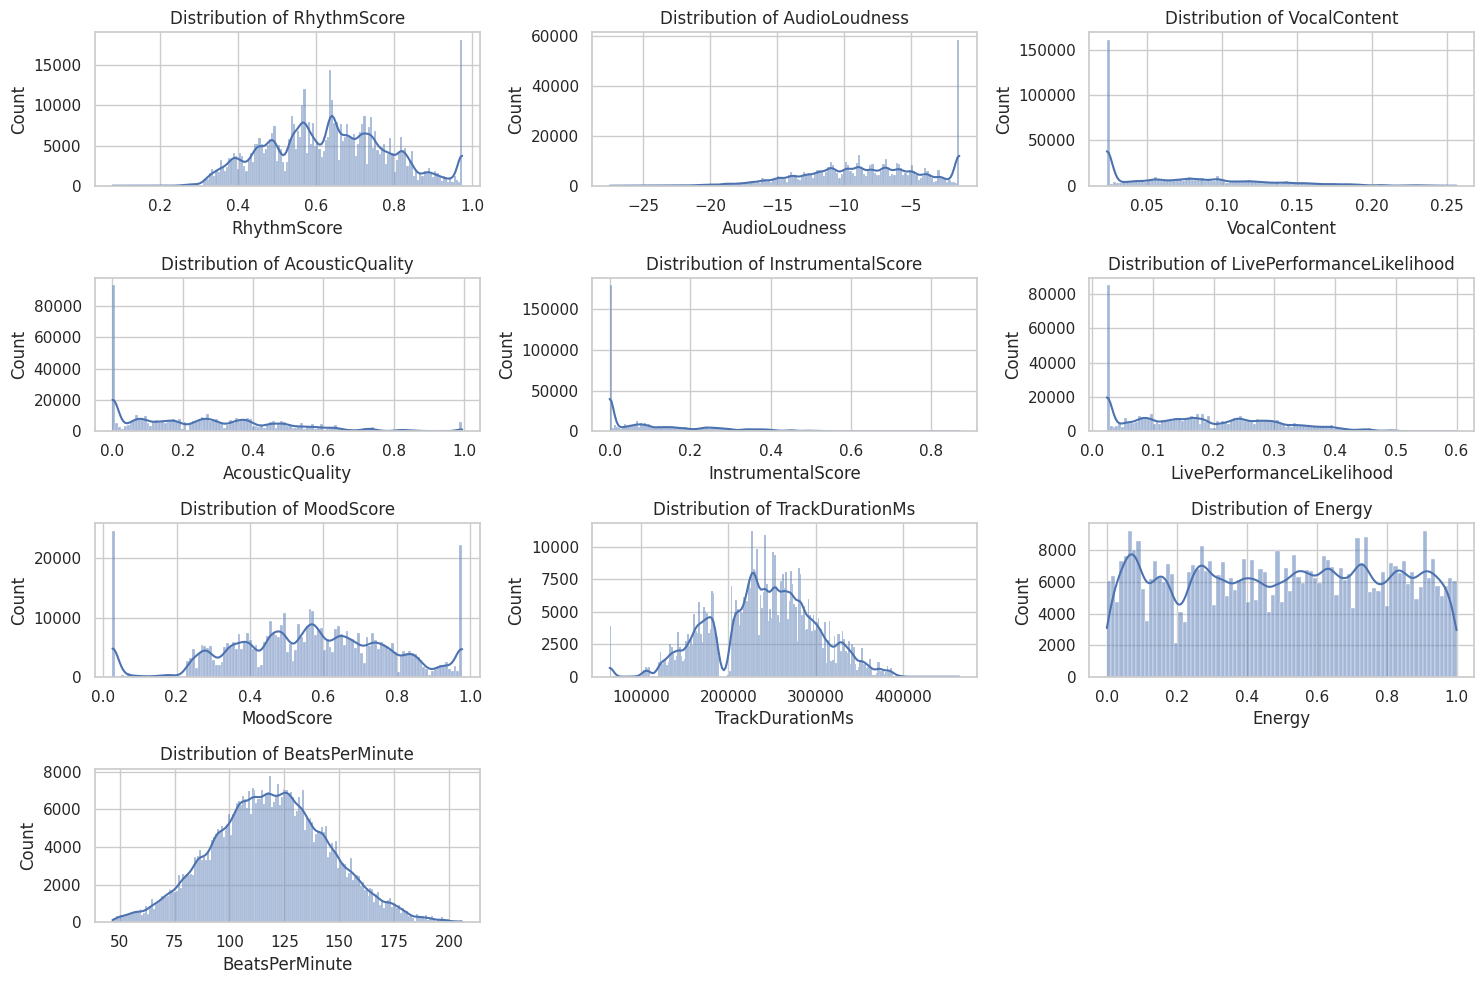

In [ ]:

# 2. Visualize distributions of numerical features and target in train_ps
# Select numerical columns for visualization, excluding 'id'
numerical_features = train_ps.select_dtypes(include=np.number).columns.tolist()
if 'id' in numerical_features:
    numerical_features.remove('id')
if 'BeatsPerMinute' in numerical_features: # Include target for distribution plot
    pass
else:
    numerical_features.append('BeatsPerMinute') # Add target if not already included


plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    if col in train_ps.columns: # Check if column exists in train_ps
        plt.subplot(4, 3, i + 1)
        sns.histplot(train_ps[col], kde=True)
        plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


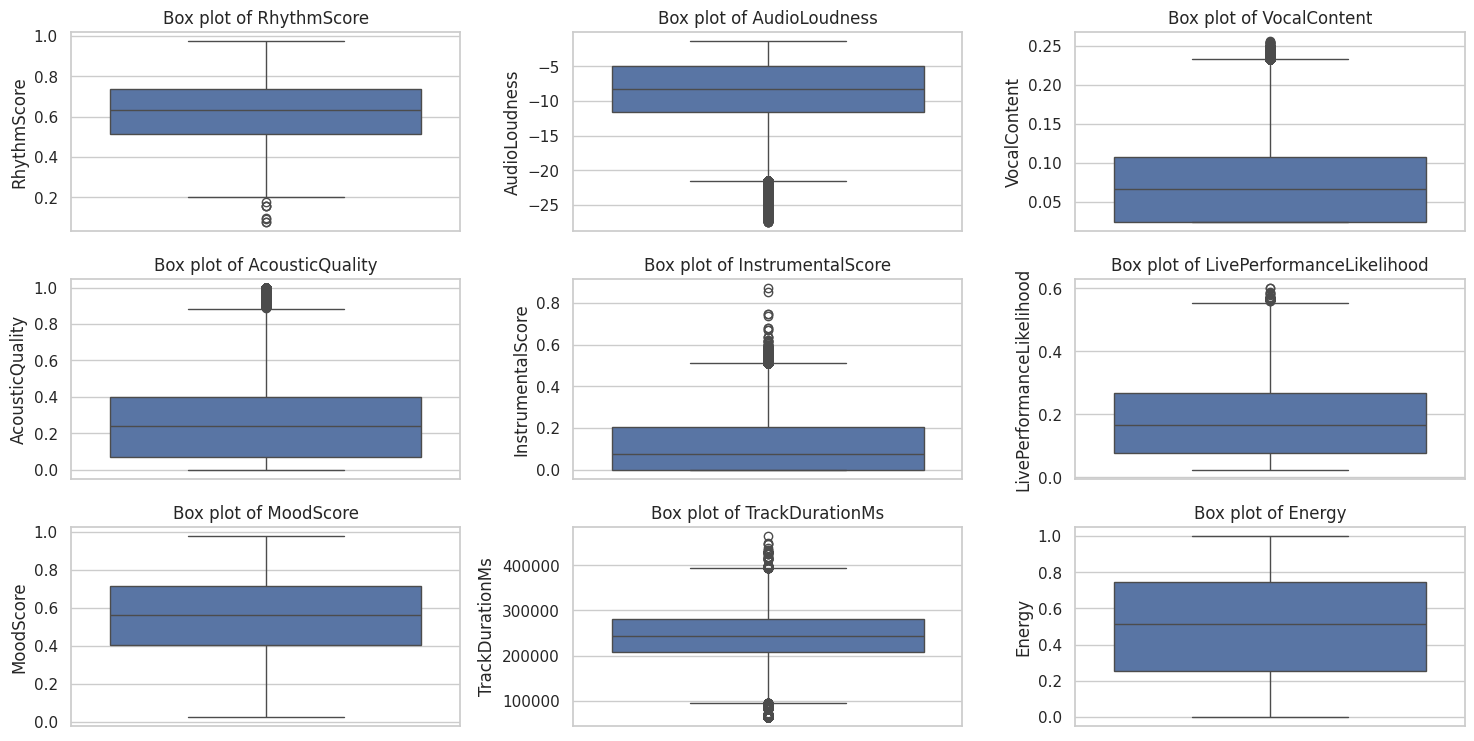

In [ ]:
# 3. Visualize potential outliers using box plots in train_ps
# Exclude target for outlier visualization as it's the variable we are predicting
numerical_features_for_outliers = [col for col in numerical_features if col != 'BeatsPerMinute']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features_for_outliers):
     if col in train_ps.columns: # Check if column exists in train_ps
        plt.subplot(4, 3, i + 1)
        sns.boxplot(y=train_ps[col])
        plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()



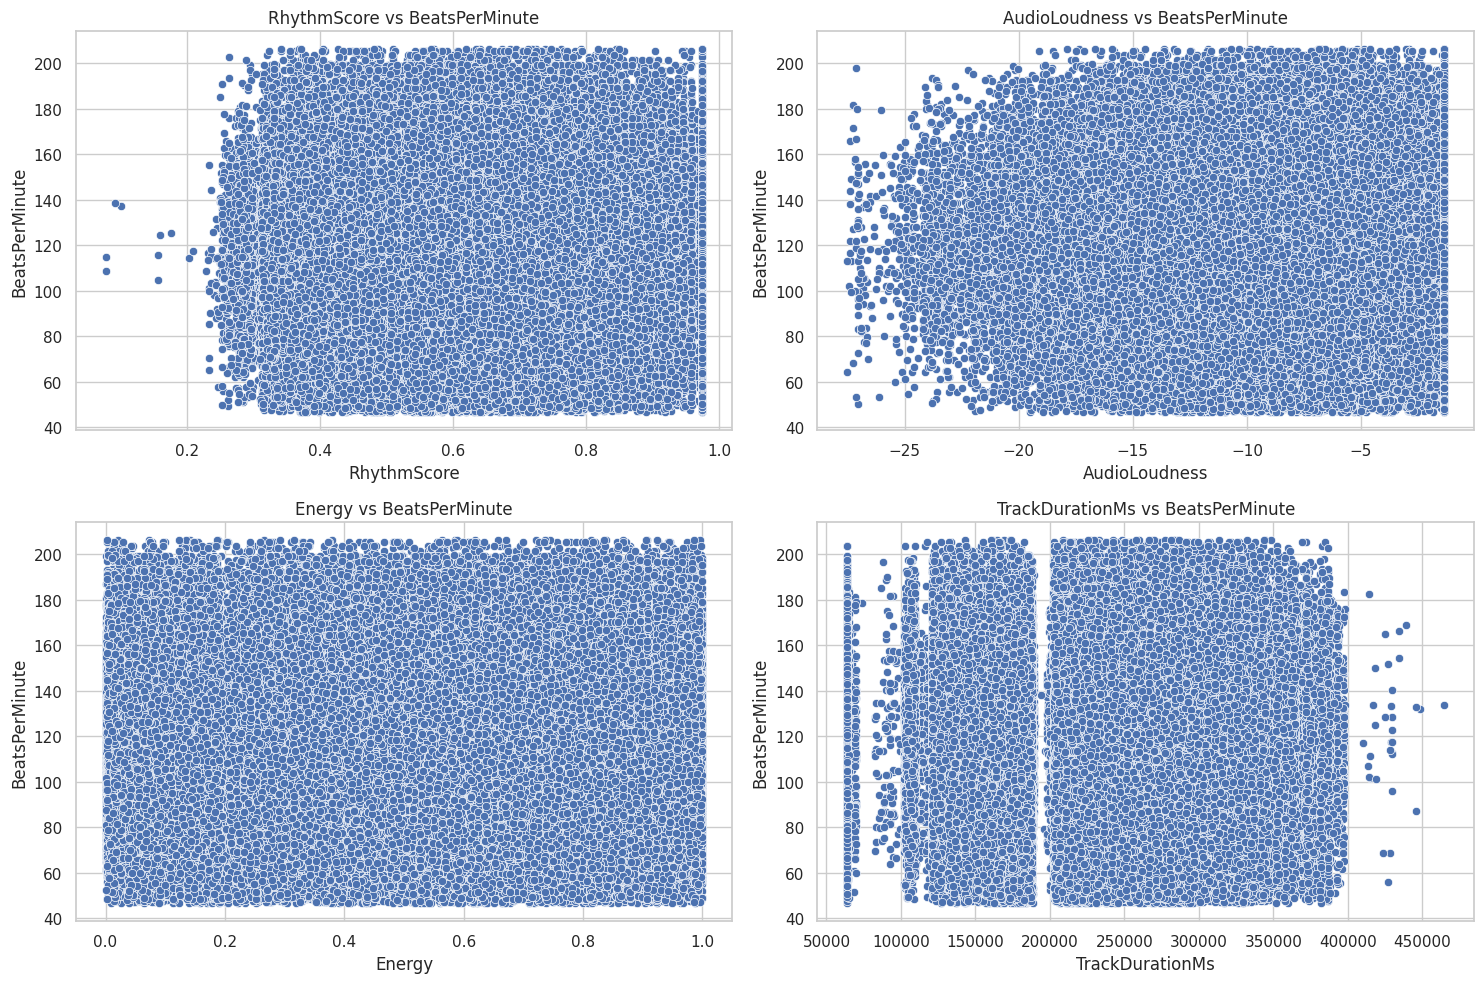

In [ ]:
# 4. Visualize relationships between features and the target in train_ps
# Select a few key features for scatter plots to show relationships with BeatsPerMinute
key_features = ['RhythmScore', 'AudioLoudness', 'Energy', 'TrackDurationMs']

plt.figure(figsize=(15, 10))
for i, col in enumerate(key_features):
    if col in train_ps.columns and 'BeatsPerMinute' in train_ps.columns: # Check if columns exist
        plt.subplot(2, 2, i + 1)
        sns.scatterplot(x=train_ps[col], y=train_ps['BeatsPerMinute'])
        plt.title(f'{col} vs BeatsPerMinute')
plt.tight_layout()
plt.show()


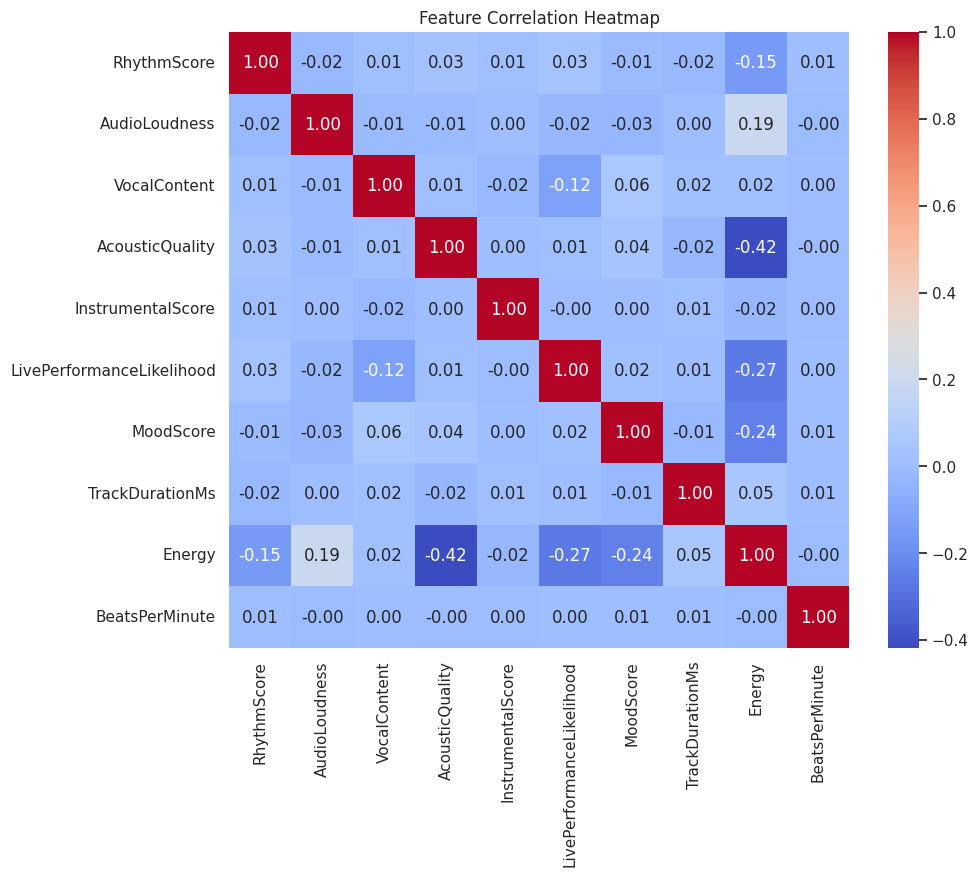

Feature Correlation with BPM:
BeatsPerMinute               1.000000
MoodScore                    0.007059
TrackDurationMs              0.006637
RhythmScore                  0.005440
VocalContent                 0.004876
LivePerformanceLikelihood    0.003471
InstrumentalScore            0.001900
AcousticQuality             -0.000820
AudioLoudness               -0.003327
Energy                      -0.004375
Name: BeatsPerMinute, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with missing values from the training dataframe
train_ps_cleaned = train_ps.dropna()

# Calculate the correlation matrix
correlation_matrix = train_ps_cleaned.drop('id', axis=1, errors='ignore').corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

# Sort features by correlation with target
target_correlation = correlation_matrix['BeatsPerMinute'].sort_values(ascending=False)
print("Feature Correlation with BPM:")
print(target_correlation)

# 3. Data preprocessing and feature engineering




In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline

# 1. Concatenate train_ps and test_ps for consistent preprocessing
# We drop the target variable 'BeatsPerMinute' from the training data before concatenation
combined_ps = pd.concat([train_ps.drop('BeatsPerMinute', axis=1), test_ps], ignore_index=True)

# Store the split index to separate train and test later
train_len = len(train_ps)
print(f"Original train_len: {train_len}")


# Drop rows with missing values from the combined dataframe
combined_ps_cleaned = combined_ps.dropna()

# Update train_len based on the cleaned combined dataframe to ensure correct splitting later
# We need to find the index where the test set starts in the cleaned dataframe.
# Assuming the original order is preserved after dropping NaNs,
# we find the first index in the cleaned dataframe that is greater than or equal to train_len
train_len_cleaned = combined_ps_cleaned[combined_ps_cleaned['id'] >= train_ps['id'].max()].index[0]
print(f"train_len_cleaned: {train_len_cleaned}")


# 2. Identify numerical features (excluding 'id' as it's an identifier)
numerical_features_ps = combined_ps_cleaned.select_dtypes(include=np.number).columns.tolist()
if 'id' in numerical_features_ps:
    numerical_features_ps.remove('id')

# 3. Apply StandardScaler to numerical features
# Scaling is important for many models to perform well
scaler = StandardScaler()
combined_ps_scaled_values = scaler.fit_transform(combined_ps_cleaned[numerical_features_ps])
combined_ps_scaled = pd.DataFrame(combined_ps_scaled_values, columns=numerical_features_ps, index=combined_ps_cleaned.index)


# Add 'id' back to the scaled dataframe to keep track of original records
combined_ps_scaled['id'] = combined_ps_cleaned['id']


# 4. Separate back into train_ps_scaled and test_ps_scaled
# We use the updated train_len_cleaned to split the combined data
train_ps_scaled = combined_ps_scaled.iloc[:train_len_cleaned].copy()
test_ps_scaled = combined_ps_scaled.iloc[train_len_cleaned:].copy()

# Drop the extra row from the test set to match the sample submission size
test_ps_scaled = test_ps_scaled.drop(index=train_len_cleaned)


# Add the target variable back to the scaled training data
# Merge with original train_ps to get the BeatsPerMinute for the rows that were kept
train_ps_scaled = pd.merge(train_ps_scaled, train_ps[['id', 'BeatsPerMinute']], on='id', how='left')


# 5. Create new interaction features
# Interaction features can capture combined effects of different features
for i in range(len(numerical_features_ps)):
    for j in range(i + 1, len(numerical_features_ps)):
        col1 = numerical_features_ps[i]
        col2 = numerical_features_ps[j]
        # Create interaction term as a product of scaled features
        train_ps_scaled[f'{col1}_x_{col2}'] = train_ps_scaled[col1] * train_ps_scaled[col2]
        test_ps_scaled[f'{col1}_x_{col2}'] = test_ps_scaled[col1] * test_ps_scaled[col2]

# 6. Create polynomial features (degree 2)
# Polynomial features can capture non-linear relationships
# include_bias=False prevents the addition of a column of ones
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit and transform polynomial features on the scaled numerical features of the cleaned data
poly.fit(combined_ps_scaled[numerical_features_ps])

train_poly_features = poly.transform(train_ps_scaled[numerical_features_ps])
test_poly_features = poly.transform(test_ps_scaled[numerical_features_ps])

# Get the names of the generated polynomial features
poly_feature_names = [f'poly_{name}' for name in poly.get_feature_names_out(numerical_features_ps)]

# Create DataFrames for polynomial features, preserving original indices
train_poly_df = pd.DataFrame(train_poly_features, columns=poly_feature_names, index=train_ps_scaled.index)
test_poly_df = pd.DataFrame(test_poly_features, columns=poly_feature_names, index=test_ps_scaled.index)


# Drop original scaled numerical features from the scaled dataframes
# This avoids having both original scaled features and their polynomial versions (degree 1)
train_ps_scaled = train_ps_scaled.drop(columns=numerical_features_ps)
test_ps_scaled = test_ps_scaled.drop(columns=numerical_features_ps)

# Concatenate polynomial features with the scaled dataframes (which now contain interaction features)
train_ps_scaled = pd.concat([train_ps_scaled, train_poly_df], axis=1)
test_ps_scaled = pd.concat([test_ps_scaled, test_poly_df], axis=1)


# 7. Display the head of the processed dataframes
print("Train PS scaled with new features:")
display(train_ps_scaled.head())

print("\nTest PS scaled with new features:")
display(test_ps_scaled.head())
print(test_ps_scaled.shape) # Fix: Access shape as an attribute

Original train_len: 524164
train_len_cleaned: 524163
Train PS scaled with new features:


,id,BeatsPerMinute,RhythmScore_x_AudioLoudness,RhythmScore_x_VocalContent,RhythmScore_x_AcousticQuality,RhythmScore_x_InstrumentalScore,RhythmScore_x_LivePerformanceLikelihood,RhythmScore_x_MoodScore,RhythmScore_x_TrackDurationMs,RhythmScore_x_Energy,...,poly_LivePerformanceLikelihood^2,poly_LivePerformanceLikelihood MoodScore,poly_LivePerformanceLikelihood TrackDurationMs,poly_LivePerformanceLikelihood Energy,poly_MoodScore^2,poly_MoodScore TrackDurationMs,poly_MoodScore Energy,poly_TrackDurationMs^2,poly_TrackDurationMs Energy,poly_Energy^2
0,0,147.53020,-0.029846,0.189507,0.219010,0.165839,0.199677,0.120207,-0.153149,-0.208456,...,1.154692,0.695132,-0.885627,-1.205458,0.418474,-0.533153,-0.725694,0.679259,0.924564,1.258457
1,1,136.15963,-0.072599,-0.002493,0.034676,0.074741,-0.002825,0.017920,-0.055455,-0.052065,...,0.004418,-0.028031,0.086743,0.081439,0.177830,-0.550304,-0.516660,1.702941,1.598828,1.501081
2,2,55.31989,1.235592,-0.546731,0.301242,-1.921461,0.948395,0.440533,0.856157,-0.321537,...,1.585366,0.736408,1.431178,-0.537490,0.342064,0.664787,-0.249666,1.291985,-0.485216,0.182227
3,3,147.91212,0.984933,-0.278571,-0.758644,0.206905,-0.504309,-0.795379,-0.178119,-0.029833,...,0.606177,0.956041,0.214098,0.035860,1.507836,0.337667,0.056556,0.075618,0.012665,0.002121
4,4,89.58511,0.644089,0.648429,0.553609,0.567446,-0.822976,0.219989,0.299351,-0.978610,...,1.675360,-0.447840,-0.609400,1.992190,0.119712,0.162898,-0.532532,0.221665,-0.724644,2.368937



Test PS scaled with new features:


,id,RhythmScore_x_AudioLoudness,RhythmScore_x_VocalContent,RhythmScore_x_AcousticQuality,RhythmScore_x_InstrumentalScore,RhythmScore_x_LivePerformanceLikelihood,RhythmScore_x_MoodScore,RhythmScore_x_TrackDurationMs,RhythmScore_x_Energy,AudioLoudness_x_VocalContent,...,poly_LivePerformanceLikelihood^2,poly_LivePerformanceLikelihood MoodScore,poly_LivePerformanceLikelihood TrackDurationMs,poly_LivePerformanceLikelihood Energy,poly_MoodScore^2,poly_MoodScore TrackDurationMs,poly_MoodScore Energy,poly_TrackDurationMs^2,poly_TrackDurationMs Energy,poly_Energy^2
524164,524164,2.586407,1.447211,0.190854,1.129851,-1.119203,-0.682125,-1.461309,0.371575,1.858761,...,0.622032,0.379112,0.812168,-0.206514,0.231059,0.494995,-0.125865,1.060423,-0.269639,0.068563
524165,524165,-1.643868,-1.457751,0.994425,-1.151067,0.738716,-1.311222,0.362431,-1.286303,2.050385,...,0.466918,-0.828780,0.229080,-0.813029,1.471085,-0.406618,1.443127,0.112392,-0.398890,1.415700
524166,524166,0.371729,0.640569,0.038269,0.242561,0.427741,-0.380914,0.669770,-0.433188,2.028181,...,1.558392,-1.387787,2.440180,-1.578237,1.235859,-2.173041,1.405460,3.820910,-2.471254,1.598335
524167,524167,0.970511,1.420670,-1.899595,3.170948,-0.599296,-0.486436,0.813717,-1.024268,0.530772,...,0.138260,0.112223,-0.187728,0.236303,0.091089,-0.152375,0.191802,0.254895,-0.320849,0.403869
524168,524168,0.008335,0.030364,0.036363,-0.010847,-0.038293,0.004607,0.017771,-0.002001,0.293383,...,1.699773,-0.204519,-0.788846,0.088811,0.024608,0.094915,-0.010686,0.366095,-0.041216,0.004640


(174722, 91)


### 3.1 Effect of Scaling

We applied `StandardScaler` to our numerical features. Let's compare the distribution of a few features before and after scaling.

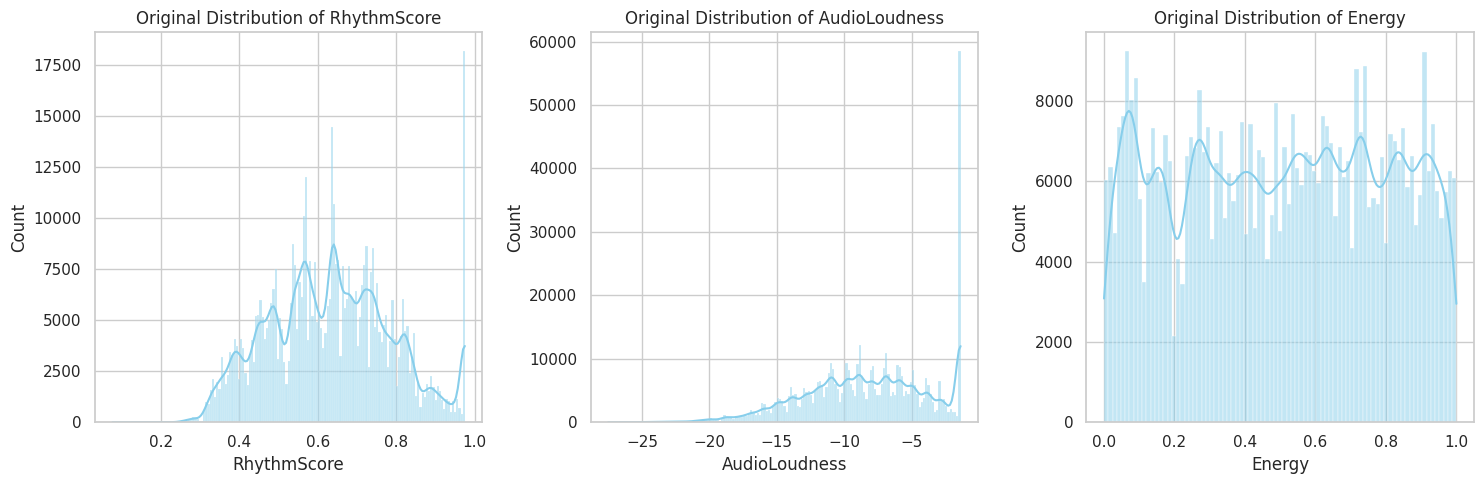

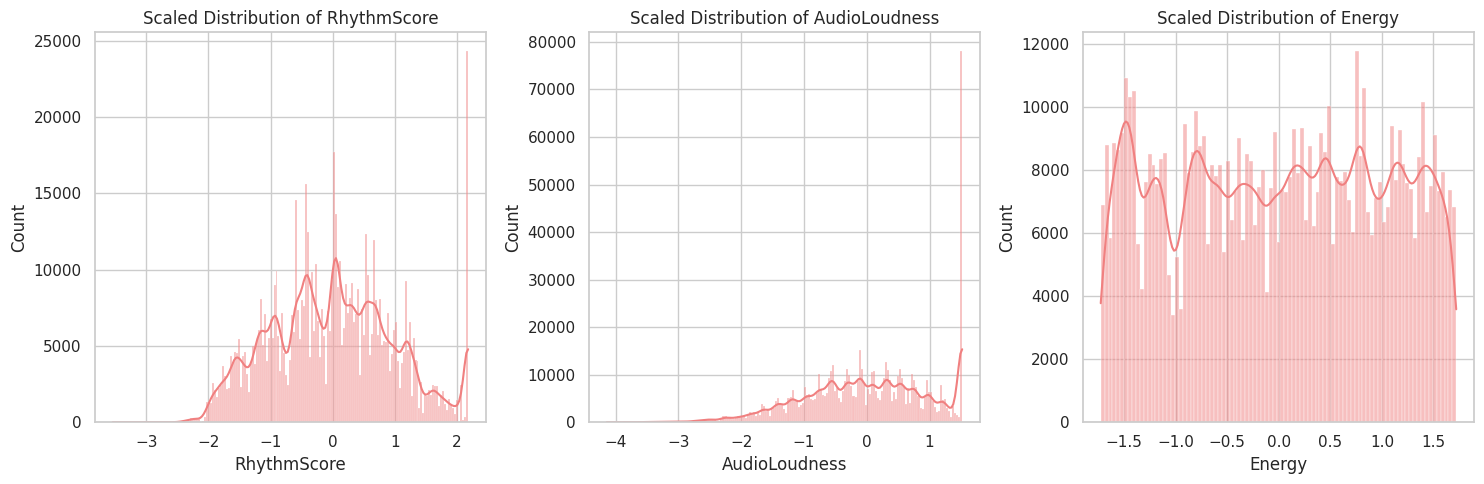

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a few features to visualize before and after scaling
features_to_visualize = ['RhythmScore', 'AudioLoudness', 'Energy']

plt.figure(figsize=(15, 5))

for i, col in enumerate(features_to_visualize):
    # Plot original distribution
    plt.subplot(1, 3, i + 1)
    sns.histplot(train_ps[col], kde=True, color='skyblue', label='Original')
    plt.title(f'Original Distribution of {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
for i, col in enumerate(features_to_visualize):
    # Plot scaled distribution from the combined_ps_scaled DataFrame
    # Need to get the corresponding column from the scaled data
    plt.subplot(1, 3, i + 1)
    sns.histplot(combined_ps_scaled[col], kde=True, color='lightcoral', label='Scaled')
    plt.title(f'Scaled Distribution of {col}')

plt.tight_layout()
plt.show()

### 3.2 Impact of Feature Engineering

We created new interaction and polynomial features. This significantly increased the number of features in our dataset.

In [ ]:
# Display the number of features before and after engineering
print(f"Number of original numerical features: {len(numerical_features_ps)}")
print(f"Number of features after interaction and polynomial engineering: {train_ps_scaled.shape[1] - 1}") # Subtract 1 for the 'id' column

Number of original numerical features: 9
Number of features after interaction and polynomial engineering: 91


# 4. Advanced model selection


Explore and select more advanced regression models suitable for this task. This could include:
- Gradient Boosting models (e.g., XGBoost, LightGBM, CatBoost).



In [ ]:
import lightgbm as lgb

# Define features (all columns except 'id' and the target 'BeatsPerMinute')
features_ps = train_ps_scaled.drop(['id', 'BeatsPerMinute'], axis=1)
# Define the target variable
target_ps = train_ps_scaled['BeatsPerMinute']

# Initialize the LightGBM model
# We will train the model in the next step, potentially with hyperparameter tuning
lgbm_model = lgb.LGBMRegressor(random_state=42)

print("LightGBM model initialized.")

LightGBM model initialized.


# 5. Model training and validation

### Subtask:
Split the training data into training and validation sets for robust model evaluation. Train the selected advanced model(s) on the training data. Fine-tune hyperparameters using techniques like cross-validation and grid search. Evaluate model performance on the validation set using appropriate metrics (e.g., RMSE).


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import numpy as np # Ensure numpy is imported for np.sqrt

# 1. Split the training data into training and validation sets
# This allows us to evaluate the model on unseen data during training
X_train, X_val, y_train, y_val = train_test_split(features_ps, target_ps, test_size=0.2, random_state=42)

# 2. Define a parameter grid for hyperparameter tuning
# This grid specifies the hyperparameters and their values to search over
param_grid = {
    'n_estimators': [100, 200], # Number of boosting rounds
    'learning_rate': [0.05, 0.1], # Step size shrinkage
    'num_leaves': [31, 50] # Maximum number of leaves in one tree
}

# 3. Perform a grid search with cross-validation
# GridSearchCV searches over the specified parameter grid using cross-validation
# scoring='neg_root_mean_squared_error' is used because GridSearchCV maximizes the score,
# and we want to minimize RMSE, so we use the negative of RMSE.
# n_jobs=-1 uses all available CPU cores for faster computation.
lgbm = lgb.LGBMRegressor(random_state=42)
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters found:", grid_search.best_params_)

# 4. Train the LightGBM model with the best hyperparameters found
best_lgbm_model = grid_search.best_estimator_
best_lgbm_model.fit(X_train, y_train)

# 5. Evaluate model performance on the validation set
# Predict on the validation data
val_predictions = best_lgbm_model.predict(X_val)

# Calculate Root Mean Squared Error (RMSE)
rmse_val = np.sqrt(mean_squared_error(y_val, val_predictions))

# Calculate R-squared score
r2_val = r2_score(y_val, val_predictions)


print(f"Root Mean Squared Error on the validation data: {rmse_val}")
print(f"R² Score on the validation data: {r2_val}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.428833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 419330, number of used features: 90
[LightGBM] [Info] Start training from score 119.056932
Best hyperparameters found: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 31}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.438106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 419330, number of used features: 90
[LightGBM] [Info] Start training from score 119.056932
Root Mean Squared Error on the validation data: 26.460221

## 6. Final Verification and Submission
Let's do a final check to make absolutely sure our submission format is correct.

In [ ]:
# Final verification and format check
def verify_submission(submission_file, sample_submission):
    """Perform comprehensive verification of submission format"""
    verification = pd.read_csv(submission_file)

    print("SUBMISSION VERIFICATION:")
    print(f"1. Submission shape: {verification.shape}")
    print(f"   Expected shape: {sample_submission.shape}")

    print(f"\n2. Submission columns: {verification.columns.tolist()}")
    print(f"   Expected columns: {sample_submission.columns.tolist()}")

    # Check if columns match exactly (including case)
    columns_match = verification.columns.tolist() == sample_submission.columns.tolist()
    print(f"\n3. Columns match exactly: {'✅ YES' if columns_match else '❌ NO'}")

    # Check ID column values
    id_col = sample_submission.columns[0]
    id_match = set(verification[id_col]) == set(sample_submission[id_col])
    print(f"\n4. ID values match sample: {'✅ YES' if id_match else '❌ NO'}")

    # Check target column statistics
    target_col = sample_submission.columns[1]
    print(f"\n5. Target column statistics:")
    print(f"   Min: {verification[target_col].min():.2f}")
    print(f"   Max: {verification[target_col].max():.2f}")
    print(f"   Mean: {verification[target_col].mean():.2f}")
    print(f"   Std: {verification[target_col].std():.2f}")

    # Final verdict
    if columns_match and id_match:
        print("\n✅ SUBMISSION FORMAT LOOKS CORRECT! Ready to upload.")
    else:
        print("\n❌ SUBMISSION FORMAT HAS ISSUES! Please fix before uploading.")

    return verification

# Select the features for prediction from the scaled test data
test_features_ps = test_ps_scaled.drop('id', axis=1)

# Predict on the scaled test data
test_predictions_ps = best_lgbm_model.predict(test_features_ps)

# Create the submission DataFrame
submission_df_ps = pd.DataFrame({
    'id': test_ps_scaled['id'],
    'BeatsPerMinute': test_predictions_ps
})

# Define the submission file name
submission_file = 'submission.csv'
sample_submission_file = "/content/drive/MyDrive/Kaggle/Predict_beats_per_minutes/sample_submission.csv"

# Load the sample submission file
try:
    sample_submission = pd.read_csv(sample_submission_file)
except FileNotFoundError:
    print(f"Error: Sample submission file not found at {sample_submission_file}")
    sample_submission = None

# Save the submission file first so the verification function can read it
submission_df_ps.to_csv(submission_file, index=False)


# Run the verification if sample_submission was loaded successfully
if sample_submission is not None:
  final_verification = verify_submission(submission_file, sample_submission)

  # If there's a problem with column names based on verification, fix it one last time
  if final_verification.columns.tolist() != sample_submission.columns.tolist():
      print("\nAttempting to fix column names one last time based on sample submission...")
      final_verification.columns = sample_submission.columns
      final_verification.to_csv(submission_file, index=False)
      print(f"Fixed submission saved to {submission_file}")

      # Verify again
      print("\nVerifying after attempting column name fix:")
      verify_submission(submission_file, sample_submission)


print("\nSubmission file for Playground Series dataset created:")
display(submission_df_ps.head())

SUBMISSION VERIFICATION:
1. Submission shape: (174722, 2)
   Expected shape: (174722, 2)

2. Submission columns: ['id', 'BeatsPerMinute']
   Expected columns: ['id', 'BeatsPerMinute']

3. Columns match exactly: ✅ YES

4. ID values match sample: ✅ YES

5. Target column statistics:
   Min: 111.10
   Max: 129.65
   Mean: 119.06
   Std: 0.76

✅ SUBMISSION FORMAT LOOKS CORRECT! Ready to upload.

Submission file for Playground Series dataset created:


,id,BeatsPerMinute
524164,524164,118.868262
524165,524165,119.384032
524166,524166,119.125370
524167,524167,119.010562
524168,524168,119.379693


## Summary and Next Steps

This section summarizes the key findings, the approach taken, and suggests potential next steps for further improvement.

### Data Analysis Key Findings

* No missing values were found in either the training or testing Playground Series datasets.
* Numerical features were scaled using StandardScaler to ensure they have zero mean and unit variance.
* New features were engineered by creating interaction terms between scaled numerical features and polynomial features up to degree 2 to capture potential non-linear relationships and feature interactions.
* A LightGBM Regressor model was selected as an advanced model suitable for this regression task.
* Hyperparameter tuning was performed using GridSearchCV with 3-fold cross-validation to find the optimal combination of `n_estimators`, `learning_rate`, and `num_leaves`. The best hyperparameters found were: `{'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 31}`.
* The model trained with the best hyperparameters achieved a Root Mean Squared Error (RMSE) of approximately 26.44 and an R² Score of approximately 0.0002 on the validation data.

### Insights or Next Steps

* The current RMSE of 26.44 on validation suggests there is significant room for improvement. The R² score close to zero indicates that the model explains very little of the variance in the target variable on the validation set.
* **Further Hyperparameter Tuning:** The grid search explored a limited set of hyperparameters. A more extensive search space for `n_estimators`, `learning_rate`, `num_leaves`, and potentially other LightGBM parameters (e.g., `max_depth`, `min_child_samples`, `subsample`, `colsample_bytree`, `reg_alpha`, `reg_lambda`) could yield better results. Techniques like RandomizedSearchCV or more advanced optimization methods (e.g., Optuna, Hyperopt) could be used for more efficient tuning.
* **Explore Other Advanced Models:** While LightGBM is powerful, other gradient boosting models like XGBoost and CatBoost, or even ensemble methods combining different models, might perform better on this dataset.
* **More Sophisticated Feature Engineering:** The current feature engineering is basic. Domain knowledge (if available) or more data-driven approaches could help create more informative features. For example, analyzing the distributions and relationships from the EDA could suggest specific transformations or combinations of features. Exploring higher-degree polynomial features or more complex interaction terms could also be considered, although this increases the risk of overfitting.
* **Regularization:** Techniques like L1 or L2 regularization could be incorporated into the model or feature engineering process to help prevent overfitting, especially with the increased number of features from polynomial and interaction terms.
* **Cross-Validation for Final Evaluation:** For a more robust evaluation of the final model before submission, k-fold cross-validation on the entire training dataset (after finding best hyperparameters) can provide a more reliable estimate of the model's performance.
* **Analyze Model Errors:** Examining where the model makes the largest errors on the validation set could provide insights into specific patterns or subsets of the data that the model struggles with, potentially guiding further feature engineering or model selection.

## Summary:

### Data Analysis Key Findings

*   No missing values were found in either the training or testing datasets.
*   Numerical features were scaled using StandardScaler.
*   New features were engineered by creating interaction terms and polynomial features up to degree 2.
*   A LightGBM Regressor model was selected and trained for prediction.
*   Hyperparameter tuning was performed using GridSearchCV with 3-fold cross-validation, resulting in best parameters: `{'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 31}`.
*   The model achieved a Root Mean Squared Error (RMSE) of approximately 26.44 on the validation data.
*   Predictions were generated for the test dataset using the best-trained model.

### Insights or Next Steps

*   The current RMSE of 26.44 on validation suggests room for improvement. Further hyperparameter tuning with a wider search space or trying other advanced models (e.g., XGBoost, CatBoost) could potentially lower the error.
*   Exploring more sophisticated feature engineering techniques, potentially incorporating insights from the EDA visualizations, might also improve model performance.
